# 01 - Is it a Bird?

For an introduction to AI, we will follow an example from [fast.ai](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb), even though we don't have all the internal knowlewdge, seeing it in action can be eye opening.

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/).

![image.png](https://imgs.xkcd.com/comics/tasks.png)

We'll do exactly that, in just a few minutes, by:

- Download images of "bird photos" with an automated search engine
- Download images of "forest photos" with an automated search engine
- Fine-tune a pretrained neural network to recognise these two groups
- Try running this model on a picture of a bird and see if it works.

## About these notebooks

This is a Jupyter notebook. Notice that we can have both prose, like this explanation, and code, like the cell below. To execute the cell below, select it and press the ▶️ (*Run this cell and Advance*) icon in the toolbar.

In [1]:
print('Hello World!')

Hello World!


The shortcut for execution is `Shift` + `Enter`. Try that in the cell below.

In [2]:
print('5 + 7 =', 5+7) 

5 + 7 = 12


Optionally, you can press the ⏩ (*Restart the kernel and run all cells*) icon to execute the whole notebook at once. Since this is a learning and not a production notebook, we recommend you step one cell at a time instead.

Notice that you can execute cells in any order, or multiple times. The history of cell execution is labeled to the left of each cell, like \[1\] indicating this is the first cell that was executed. Most notebooks expect a linear progression, but you can re-run any cell at any time.

## Step 1: Download images of birds and non-birds

We can use the duck duck go search engine to look for photos, get their URL, and then download the images.

In [3]:
from duckduckgo_search import DDGS

# We need to redefine this fast.ai function to work with newer versions of duckduckgo_search
def search_images(term, max_images=200):
    with DDGS(headers = {'Accept-Encoding': 'gzip, deflate, br'}) as ddgs:
        results = ddgs.images(keywords=term)
        images = [result.get("image") for result in results[:max_images]] #  https://stackoverflow.com/a/78327127
        #images = [next(results).get('image') for _ in range(max_images)] # Gives iterator error
    return L(images)

Lately, duckduckgo has been throttling search results. If the Pexels API KEY is defined, replace the sreach function

In [4]:
import os, time, requests

API_KEY = os.environ.get("PEXELS_API_KEY")

In [5]:
if API_KEY != "NONE":
    print ("Using Pexels search engine")
    # Notice that we're redefining the original search function
    def search_images(term, max_images=200, *, size="large2x", per_page=80, delay_between_pages=0.25, api_key=API_KEY, **filters):
        """
        Pexels-backed replacement for DDGS search_images.
        Returns L(urls) with up to max_images items.
        Requires env var PEXELS_API_KEY.
        
        size: one of ["original","large2x","large","medium","small","portrait","landscape","tiny"]
        filters: optional Pexels params like orientation="landscape", color="green", locale="en-US"
        """
        if not API_KEY:
            raise RuntimeError("PEXELS_API_KEY not set in environment")
    
        headers = {"Authorization": api_key}
        images, seen_ids = [], set()
        page = 1
    
        while len(images) < max_images:
            params = {
                "query": term,
                "per_page": min(per_page, 80),  # Pexels max
                "page": page,
                **filters
            }
            r = requests.get("https://api.pexels.com/v1/search", headers=headers, params=params, timeout=30)
            r.raise_for_status()
            photos = r.json().get("photos", [])
            if not photos:
                break
    
            for p in photos:
                pid = p.get("id")
                if pid in seen_ids: 
                    continue
                seen_ids.add(pid)
                src = p.get("src") or {}
                url = src.get(size) or src.get("original") or src.get("large") or src.get("medium")
                if url:
                    images.append(url)
                    if len(images) >= max_images:
                        break
    
            page += 1
            time.sleep(delay_between_pages)
    
        return L(images)
else:
    print ("Using Duckduckgo search engine")

Using Pexels search engine


In [6]:
from fastcore.all import *

In [7]:
urls = search_images('bird photos', max_images=200) # Get a list of images, size 1
urls[0] # Print URL

'https://images.pexels.com/photos/20128333/pexels-photo-20128333.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940'

In [8]:
# Save the file
from fastdownload import download_url
dest = 'data/bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('data/bird.jpg')

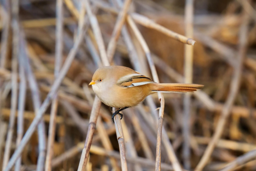

In [9]:
# Show the saved image file
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos"

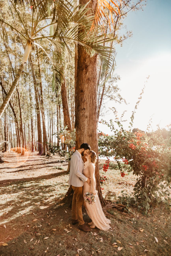

In [10]:
download_url(search_images('forest photos', max_images=1)[0], 'data/forest.jpg', show_progress=False)
Image.open('data/forest.jpg').to_thumb(256,256)

Let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder. This might take a while. If `[*]` is next to the cell, it means the cell is still executing.

In [11]:
## First, let's delete any existing images, otherwise we might run into out of memory errors when trying to fit them all at once
import os
import glob

files = glob.glob('data/bird_or_not/bird/*')
for f in files:
    os.remove(f)
files = glob.glob('data/bird_or_not/forest/*')
for f in files:
    os.remove(f)

In [12]:
searches = 'forest','bird'
path = Path('data/bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them.

In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). With `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

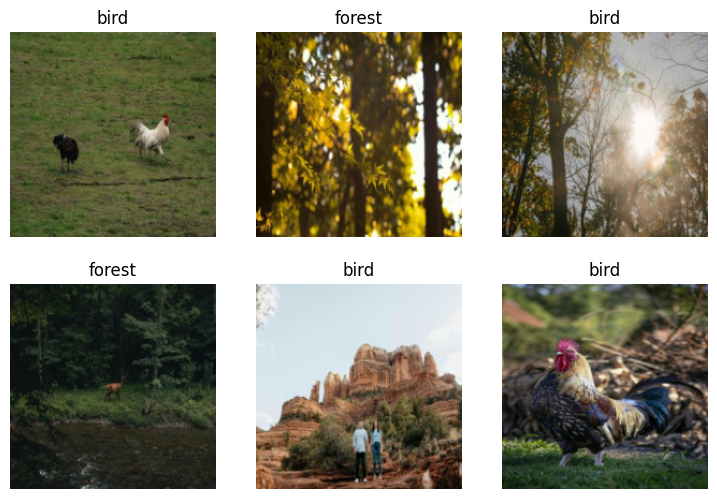

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(
    path
    # ,
    # bs=64,                 # your choice
    # num_workers=4,         # try 4–8 if /dev/shm is big now
    # prefetch_factor=2,     # default is 2; keep it unless you’re tight on /dev/shm
    # pin_memory=True,       # good for GPU
    # persistent_workers=True 
)

dls.show_batch(max_n=6)

Here is what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,
    
To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]
    
Before training, resize each image to 192x192 pixels by \"squishing\" it (as opposed to cropping it).


Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 76.1MB/s]


In [16]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 42, in fetch
    data = next(self.dataset_iter)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/fastai/data/load.py", line 140, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.11/site-packages/fastai/data/load.py", line 185, in do_batch
    def do_batch(self, b): return self.retain(self.create_batch(self.before_batch(b)), b)
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/fastai/data/load.py", line 181, in create_batch
    try: return (fa_collate,fa_convert)[self.prebatched](b)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/fastai/data/load.py", line 54, in fa_collate
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/fastai/data/load.py", line 54, in <listcomp>
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
                     ^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/fastai/data/load.py", line 53, in fa_collate
    return (default_collate(t) if isinstance(b, _collate_types)
            ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 159, in collate
    return collate_fn_map[collate_type](
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 270, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/storage.py", line 1203, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/storage.py", line 416, in _new_shared
    return cls._new_using_fd_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: unable to write to file </torch_5635_3077833734_0>: No space left on device (28)


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) 

## Step 3:

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('data/bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

You've created a binary classifier. Good job!

**Next Notebook: [02-Datasets](02-Datasets.ipynb)**